In [79]:
import jax
import jax.numpy as jnp
from typing import Any
from flax import linen as nn
from jax import random, grad, vmap, jit
from pikan.model_utils import gradf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import optax

def animate_3d_array(data, cmap='jet', interval=50):
    fig, ax = plt.subplots()
    im = ax.imshow(data[:, :, 0], cmap=cmap, origin='lower', interpolation='nearest')
    plt.colorbar(im, ax=ax)

    def update(t):
        im.set_array(data[:, :, t])
        ax.set_title(f'Time step: {t}')
    
    anim = FuncAnimation(fig, update, frames=data.shape[2], interval=interval)
    
    plt.close(fig)  # Prevent static frame from showing
    
    # Return HTML representation of the animation for embedding in Jupyter
    return HTML(anim.to_jshtml())

def load_ns_data():
    data = np.load('ns_tori.npy', allow_pickle=True).item()

    for key in data.keys() - {"viscosity"}:
        data[key] = np.moveaxis(data[key], 0, -1)

    return data['u'], data['v'], data['w'], data['x'], data['y'], data['t']

In [153]:
from jax import jacrev, hessian, vmap

class NS_torus():
    def __init__(self, model, u0, v0, w0, x_star, y_star):
        self.model = model
        self.RE = 100
        
        self.neural_net_fn = vmap(self.neural_net, (None, 0,0,0))
            
        self.r_net_fn = vmap(self.r_net, (None, 0,0,0))
        self.u_net_fn = vmap(self.u_net, (None, 0,0,0))
        self.v_net_fn = vmap(self.v_net, (None, 0,0,0))
        self.w_net_fn = vmap(self.w_net, (None, 0,0,0))
        
        self.u0 = u0.reshape(-1)
        self.v0 = v0.reshape(-1)
        self.w0 = w0.reshape(-1)
        
        self.x_star = x_star.reshape(-1)
        self.y_star = y_star.reshape(-1)
        
    def neural_net(self, params, x, y, t):
        collocs = jnp.stack([x,y,t])
        outputs = self.model.apply(params, collocs)

        u = outputs[0]
        v = outputs[1]
        return u, v

    def u_net(self, params, x, y, t):
        u, _ = self.neural_net(params,x,y,t)
        return u
    
    def v_net(self, params, x, y, t):
        _, v = self.neural_net(params, x,y,t)
        return v

    def w_net(self, params, x, y, t):
        v_x = grad(self.v_net, argnums=1)(params,x,y,t)
        u_y = grad(self.u_net, argnums=2)(params,x,y,t)
        
        return v_x - u_y
    
    def r_net(self, params, x, y, t):
        # Compute all derivatives once
        jacobian = jacrev(self.w_net, argnums=(1, 2, 3))(params, x, y, t)
        w_x, w_y, w_t = jacobian[0], jacobian[1], jacobian[2]

        # Advection term
        u, v = self.neural_net(params, x, y, t)

        # Compute second derivatives efficiently
        hess = hessian(self.w_net, argnums=(1, 2))(params, x, y, t)

        # Extract the second derivatives for Laplacian computation
        w_xx = hess[0][0]  # Second derivative w_xx = ∂²w/∂x²
        w_yy = hess[1][1]  # Second derivative w_yy = ∂²w/∂y²

        # Equation 1: w_t + u * grad w - 1/Re * Laplacian w
        eq1 = w_t + (u * w_x + v * w_y) - (1 / self.RE) * (w_xx + w_yy)

        # Equation 2: u_x + v_y = 0 (incompressibility condition)
        u_x = jacobian[0]
        v_y = jacobian[1]
        eq2 = u_x + v_y

        return eq1, eq2

    
    @partial(jit, static_argnums=(0,))
    def loss(self, params, collocs): # collocs shape (BS, 3)
        t0 = jnp.zeros_like(self.x_star)

        u0 = self.u_net_fn(params, self.x_star, self.y_star, t0)
        v0 = self.v_net_fn(params, self.x_star, self.y_star, t0)
        w0 = self.w_net_fn(params, self.x_star, self.y_star, t0)
        
        u0_loss = jnp.mean((u0 - self.u0)**2)
        v0_loss = jnp.mean((v0 - self.v0)**2)
        w0_loss = jnp.mean((w0 - self.w0)**2)
        
        ic_loss = u0_loss + v0_loss + w0_loss
        
        eq1, eq2 = self.r_net_fn(params, collocs[:, 0], collocs[:, 1], collocs[:, 2])
        res_loss = jnp.mean(eq1**2) + jnp.mean(eq2**2)
        
#        res_loss = 0 # SANITY CHECK
        new_loc_w = None
        return 1e-3 * res_loss + ic_loss, new_loc_w

In [154]:
# model_utils.py

import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from typing import Callable, Optional
from dataclasses import field
from typing import List
from scipy.stats.qmc import Sobol
import numpy as np
import matplotlib.pyplot as plt
import time
from jaxkan.models.KAN import KAN

from jax.nn.initializers import normal

class FourierFeats(nn.Module):
    num_output: int
    embed_scale = 1
    std = 10
    
    @nn.compact
    def __call__(self, x):
        kernel = self.param(
            "kernel", self.std*normal(self.embed_scale), (x.shape[-1], self.embed_dim // 2)
        )
        y = jnp.concatenate(
            [jnp.cos(jnp.dot(x, kernel)), jnp.sin(jnp.dot(x, kernel))], axis=-1
        )
        return y

    
class GeneralizedMLP(nn.Module):
    kernel_init: Callable
    num_input: int
    num_output: int
    use_fourier_feats: bool = False  # Whether to use FourierFeats as the first layer
    layer_sizes: List[int] = field(default_factory=list)

    std = 10
    mean = 0

    @nn.compact
    def __call__(self, x):
        # Add periodic embeddings to the first two axes
        if self.use_fourier_feats:
            x = jnp.concatenate([
                jnp.cos(x[0]), jnp.sin(x[0]),
                jnp.cos(x[1]), jnp.sin(x[1]),
                x[2],  # Leave other axes unchanged
            ], axis=-1)

        # Add hidden layers
        for idx, size in enumerate(self.layer_sizes):
            if self.use_fourier_feats and idx==0:
                x = FourierFeats(size)(x)
            else:
                x = nn.Dense(size, kernel_init=self.kernel_init)(x)
                x = nn.tanh(x)

        # Final output layer
        x = nn.Dense(self.num_output, kernel_init=self.kernel_init)(x)
        return x


In [155]:
model = GeneralizedMLP(
    kernel_init=nn.initializers.glorot_normal(),
#    use_fourier_feats=True,
    num_input=3,
    num_output=2,
    layer_sizes=[256, 256, 256, 256] # first is fourier
)

dp = jnp.ones(3)
params = model.init(random.PRNGKey(0), dp)
model.apply(params, dp)

Array([0.03605359, 0.07411801], dtype=float32)

In [156]:
u,v,w,x,y,t = load_ns_data()
x_star, y_star = jnp.meshgrid(x, y)

# u.shape
# x.shape
u.shape, v.shape, w.shape

((128, 128, 201), (128, 128, 201), (128, 128, 201))

In [157]:
jnp.abs(w).mean()

Array(1.5905291, dtype=float32)

In [158]:
u[:, :, 0].shape, v[:, :, 0].shape, w[:, :, 0].shape

((128, 128), (128, 128), (128, 128))

In [159]:
ns_torus = NS_torus(
    model, 
    u[:, :, 0], v[:, :, 0], w[:, :, 0],
    x_star, y_star,
)

BS = 32
collocs = jnp.ones((BS, 3))
ns_torus.loss(params, collocs)

dp = jnp.ones(3)
ns_torus.neural_net(params, dp[0],dp[1],dp[2])

(Array(0.03605359, dtype=float32), Array(0.07411801, dtype=float32))

In [160]:
EPOCHS = 1000

# Define a cosine decay learning rate schedule
# Learning rate schedule (cosine decay)
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-3,      # Initial learning rate
    decay_steps=2000,     # Total number of decay steps
    alpha=0.1             # Final learning rate multiplier
)

# Optimizer setup with Adam
optimizer = optax.adamw(
    learning_rate=schedule_fn,
    b1=0.9,               # Beta1
    b2=0.999,             # Beta2
    eps=1e-8              # Epsilon
)

opt_state = optimizer.init(params)

In [161]:
from pikan.model_utils import sobol_sample
from tqdm import tqdm 

BS = 1024
# x,y,t
collocs = sobol_sample(np.array([0,0,0]), np.array([2*np.pi, 2*np.pi, 1]), BS)
collocs.shape

(1024, 3)

Loss  13.02127934:   0%|          | 0/1000 [00:07<?, ?it/s]

5.001695 1.316351 10.834219


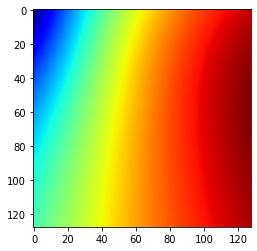

Loss  12.90747452:   1%|          | 10/1000 [00:18<21:24,  1.30s/it] 

0.9738435 1.1594367 10.675017


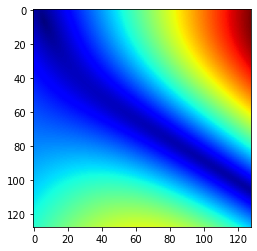

Loss  12.64892960:   2%|▏         | 20/1000 [00:33<20:09,  1.23s/it]

1.0335544 1.048777 10.575249


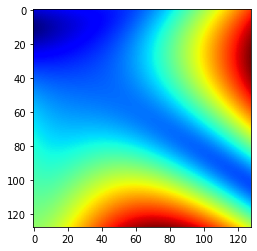

Loss  12.37662792:   3%|▎         | 30/1000 [00:46<19:44,  1.22s/it]

0.9666337 0.9724767 10.44708


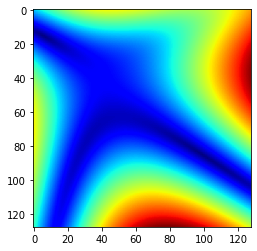

Loss  12.20518494:   4%|▍         | 40/1000 [00:57<16:52,  1.05s/it]

0.973709 0.9069441 10.307843


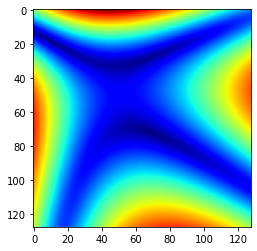

Loss  12.12156868:   5%|▌         | 50/1000 [01:09<16:30,  1.04s/it]

0.99767274 0.8819599 10.242695


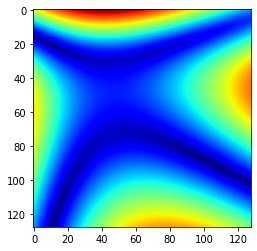

Loss  12.06672001:   6%|▌         | 60/1000 [01:20<16:48,  1.07s/it]

0.9824901 0.8654846 10.211856


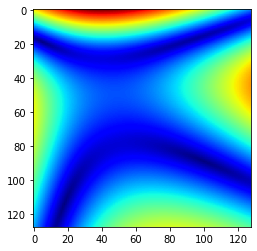

Loss  12.03013134:   7%|▋         | 70/1000 [01:32<18:27,  1.19s/it]

0.9683318 0.8763279 10.157231


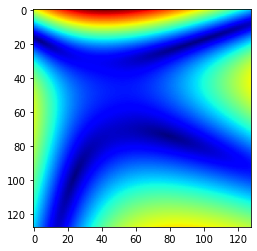

Loss  11.90226173:   8%|▊         | 80/1000 [01:43<17:07,  1.12s/it]

0.9635539 0.8727076 10.058068


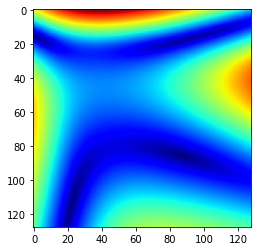

Loss  11.70047188:   9%|▉         | 90/1000 [01:55<17:02,  1.12s/it]

0.9632246 0.87141955 9.832966


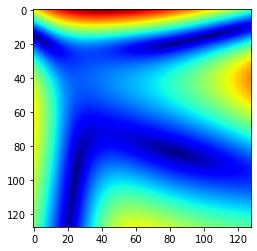

Loss  11.29934120:  10%|█         | 100/1000 [02:06<15:50,  1.06s/it]

0.9455375 0.9454053 9.35614


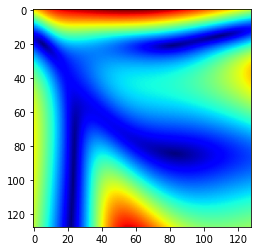

Loss  10.78100300:  11%|█         | 110/1000 [02:20<20:27,  1.38s/it]

0.9286475 1.3317686 8.687979


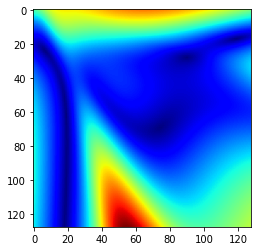

Loss  10.30809879:  12%|█▏        | 120/1000 [02:32<17:44,  1.21s/it]

0.89610755 1.2507188 8.018154


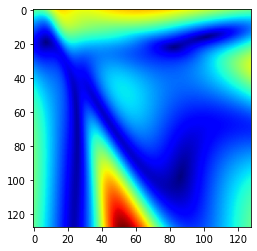

Loss  9.79017830:  13%|█▎        | 130/1000 [02:44<16:45,  1.16s/it] 

0.85596627 1.3308545 7.5168343


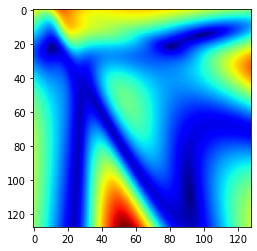

Loss  9.31574154:  14%|█▍        | 140/1000 [02:58<19:23,  1.35s/it]

0.80421364 1.4662008 7.0058727


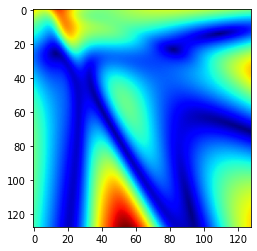

Loss  8.91576958:  15%|█▌        | 150/1000 [03:09<15:54,  1.12s/it]

0.7994772 1.5334117 6.5401773


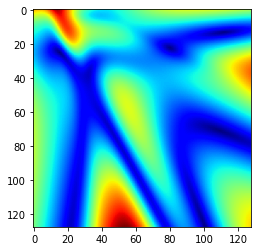

Loss  8.58247662:  16%|█▌        | 160/1000 [03:21<15:45,  1.13s/it]

0.82399094 1.5523903 6.161203


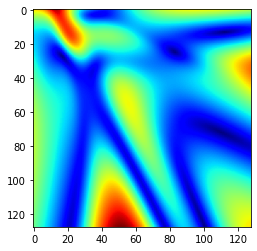

Loss  8.22558117:  17%|█▋        | 170/1000 [03:34<19:52,  1.44s/it]

0.8547789 1.550478 5.772727


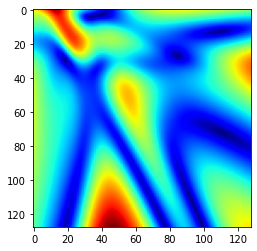

Loss  7.83642912:  18%|█▊        | 180/1000 [03:46<15:02,  1.10s/it]

0.86176413 1.5788825 5.35538


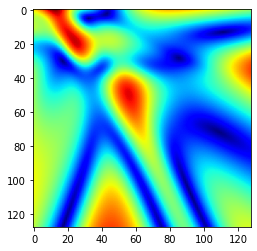

Loss  7.31264687:  19%|█▉        | 190/1000 [03:58<14:38,  1.08s/it]

0.81611127 1.5106914 4.880879


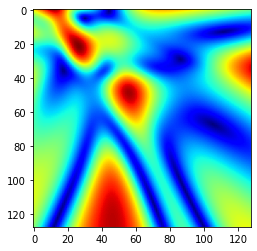

Loss  6.61446857:  20%|██        | 200/1000 [04:10<15:57,  1.20s/it]

0.79608476 1.406517 4.305292


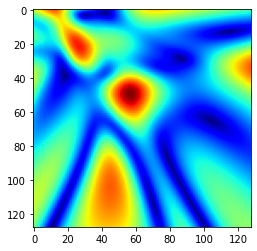

Loss  5.91974068:  21%|██        | 210/1000 [04:21<13:36,  1.03s/it]

0.8024204 1.3533744 3.6683426


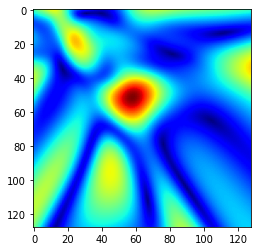

Loss  5.41247845:  22%|██▏       | 220/1000 [04:32<13:36,  1.05s/it]

0.8241488 1.2904503 3.2054443


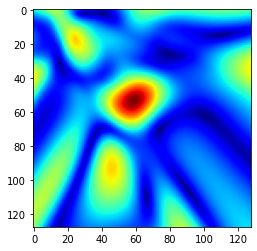

Loss  4.98016214:  23%|██▎       | 230/1000 [04:44<15:01,  1.17s/it]

0.81695205 1.2285155 2.841712


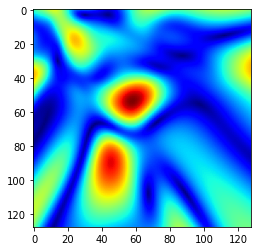

Loss  4.64069796:  24%|██▍       | 240/1000 [04:55<13:02,  1.03s/it]

0.8127108 1.2274292 2.5195718


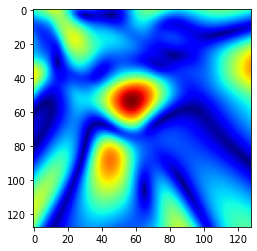

Loss  4.34085751:  25%|██▌       | 250/1000 [05:06<13:12,  1.06s/it]

0.8229434 1.1795049 2.2650008


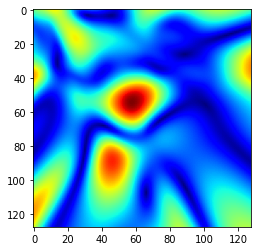

Loss  4.01048756:  26%|██▌       | 260/1000 [05:19<16:12,  1.31s/it]

0.86824536 1.1763172 2.0046275


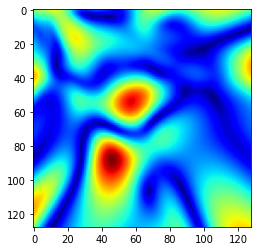

Loss  3.73041391:  27%|██▋       | 270/1000 [05:30<13:00,  1.07s/it]

0.8802997 1.154852 1.6690938


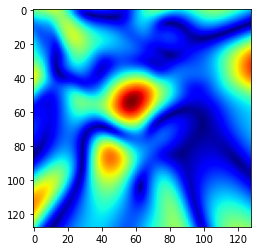

Loss  3.51518631:  28%|██▊       | 280/1000 [05:41<12:58,  1.08s/it]

0.9042985 1.0430268 1.4884074


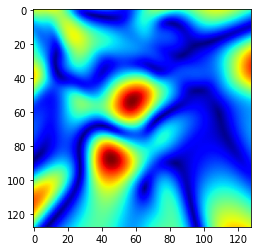

Loss  3.35406303:  29%|██▉       | 290/1000 [05:53<13:30,  1.14s/it]

0.9262227 1.0177963 1.3437364


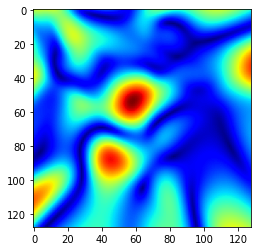

Loss  3.22295260:  30%|███       | 300/1000 [06:04<11:55,  1.02s/it]

0.9525405 0.97939265 1.2302408


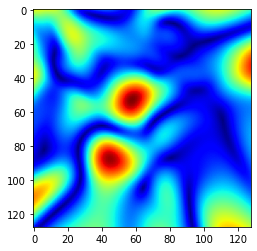

Loss  3.13115168:  31%|███       | 310/1000 [06:15<12:24,  1.08s/it]

0.9472457 0.9733174 1.1533656


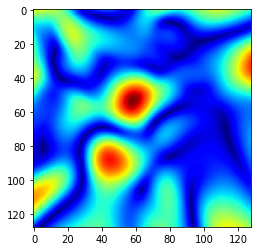

Loss  3.05656147:  32%|███▏      | 320/1000 [06:27<12:27,  1.10s/it]

0.9573764 0.9567711 1.0831466


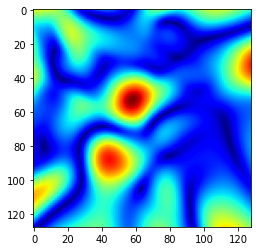

Loss  3.00356889:  33%|███▎      | 330/1000 [06:38<11:20,  1.02s/it]

0.9610566 0.94895446 1.0264944


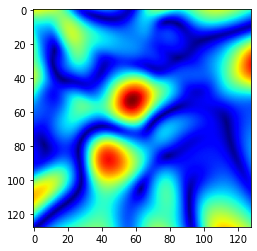

Loss  2.93422246:  34%|███▍      | 340/1000 [06:49<11:44,  1.07s/it]

0.94986403 0.9494921 0.98001236


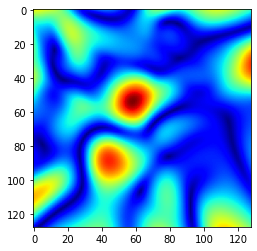

Loss  2.88837862:  35%|███▌      | 350/1000 [07:01<12:47,  1.18s/it]

0.95390177 0.94386876 0.92375267


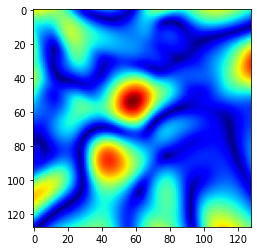

Loss  2.83074164:  36%|███▌      | 360/1000 [07:11<10:30,  1.02it/s]

0.96262753 0.9281916 0.8801902


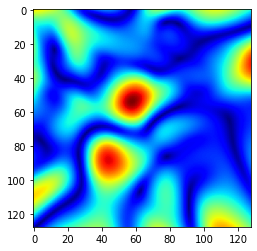

Loss  2.77986169:  37%|███▋      | 370/1000 [07:23<12:14,  1.17s/it]

0.9569974 0.92862314 0.8385153


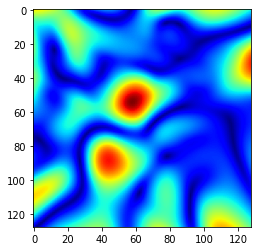

Loss  2.80417562:  38%|███▊      | 380/1000 [07:35<12:14,  1.19s/it]

0.9462216 0.94978523 0.88276184


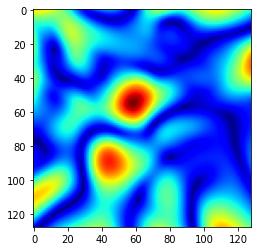

Loss  2.74677014:  39%|███▉      | 390/1000 [07:47<10:46,  1.06s/it]

0.97376686 0.9180266 0.77118653


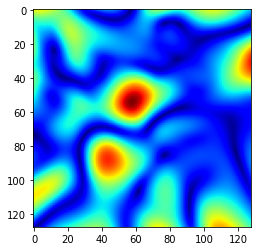

Loss  2.68443155:  40%|████      | 400/1000 [08:01<14:50,  1.48s/it]

0.9725992 0.91539264 0.7451589


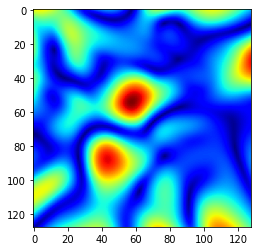

Loss  2.63759255:  41%|████      | 410/1000 [08:12<10:57,  1.11s/it]

0.9556701 0.91318315 0.7127105


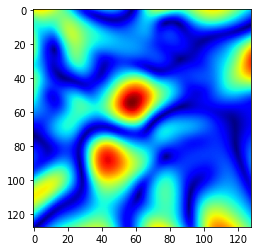

Loss  2.60983133:  42%|████▏     | 420/1000 [08:23<10:08,  1.05s/it]

0.95179254 0.91519165 0.6951201


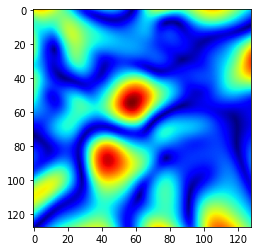

Loss  2.67585444:  43%|████▎     | 430/1000 [08:35<10:26,  1.10s/it]

0.9610725 0.90881145 0.68570685


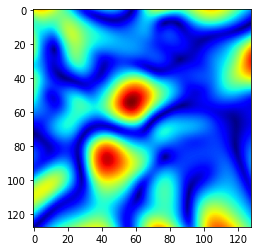

Loss  2.58123755:  44%|████▍     | 440/1000 [08:47<10:56,  1.17s/it]

0.95115644 0.9055499 0.66720045


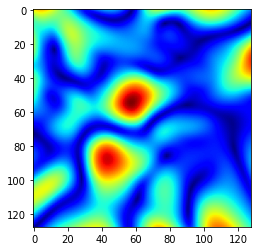

Loss  2.55005741:  45%|████▌     | 450/1000 [08:58<09:21,  1.02s/it]

0.9398704 0.912016 0.6440641


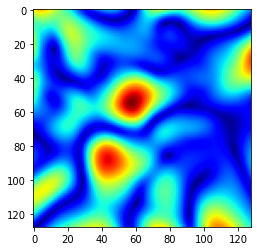

Loss  2.52238798:  46%|████▌     | 460/1000 [09:10<09:28,  1.05s/it]

0.9333476 0.9106798 0.62576175


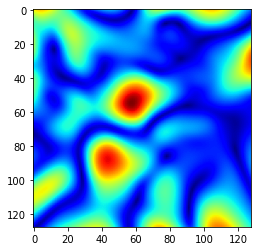

Loss  2.49868202:  47%|████▋     | 470/1000 [09:23<10:43,  1.22s/it]

0.9329808 0.9107709 0.61010283


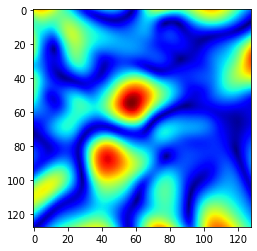

Loss  2.48544717:  48%|████▊     | 480/1000 [09:41<15:53,  1.83s/it]

0.9235993 0.9113122 0.6041945


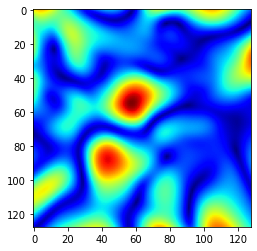

Loss  2.48827171:  49%|████▉     | 490/1000 [27:09<43:51:06, 309.54s/it]

0.91426027 0.9148596 0.6116934


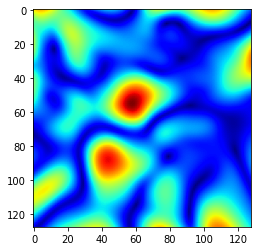

Loss  2.45722651:  50%|█████     | 500/1000 [1:15:58<62:24:30, 449.34s/it]

0.9181684 0.9129053 0.57903206


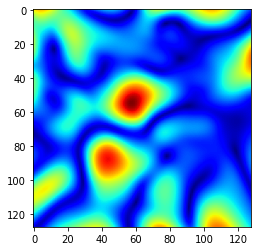

Loss  2.44755483:  51%|█████     | 510/1000 [1:42:14<6:15:00, 45.92s/it]  

0.9219859 0.90991986 0.57019544


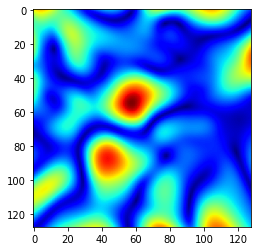

Loss  2.52661061:  52%|█████▏    | 520/1000 [2:11:39<42:50:07, 321.27s/it]

0.96606845 0.9184558 0.58636075


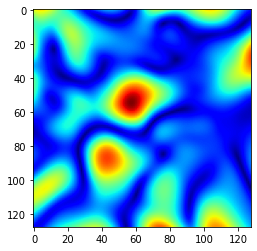

Loss  2.44210243:  53%|█████▎    | 530/1000 [3:15:12<62:26:02, 478.22s/it]

0.89995754 0.9145336 0.56796324


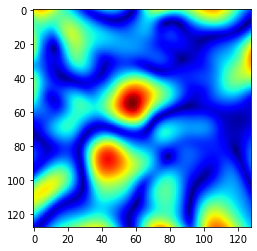

Loss  2.41283417:  54%|█████▍    | 540/1000 [4:07:47<43:20:49, 339.24s/it]

0.90108526 0.91130006 0.56201863


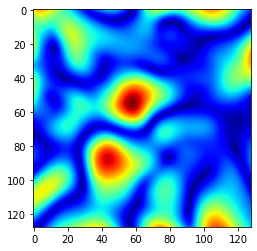

Loss  2.40268421:  55%|█████▌    | 550/1000 [5:12:23<29:45:25, 238.06s/it]

0.90419483 0.9123409 0.5413494


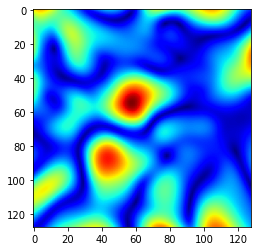

Loss  2.39218879:  56%|█████▌    | 560/1000 [6:18:50<66:43:45, 545.97s/it]

0.8947799 0.9194067 0.5385443


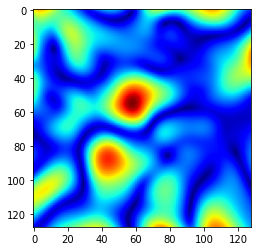

Loss  2.44180989:  57%|█████▋    | 570/1000 [6:51:00<40:10:25, 336.34s/it]

0.9051124 0.9540428 0.5412371


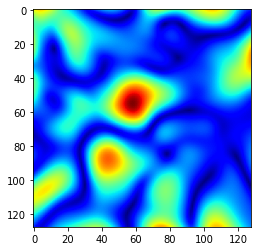

Loss  2.38823938:  58%|█████▊    | 580/1000 [7:58:02<55:56:11, 479.46s/it]

0.8965449 0.91107666 0.53612375


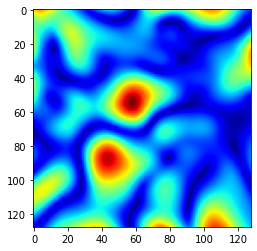

Loss  2.36240005:  59%|█████▉    | 590/1000 [8:40:26<17:36:44, 154.64s/it]

0.8854463 0.91347873 0.52499825


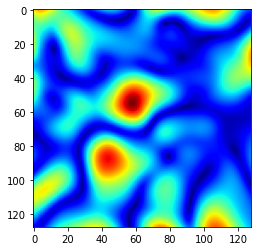

Loss  2.35572982:  60%|██████    | 600/1000 [9:28:59<24:09:53, 217.48s/it]

0.8889821 0.91496015 0.5140934


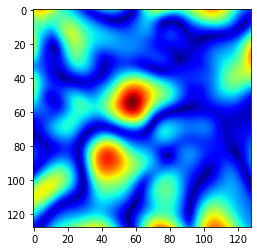

Loss  2.34982109:  61%|██████    | 610/1000 [10:38:04<43:28:10, 401.26s/it]

0.8839163 0.910685 0.5163095


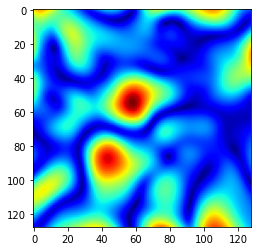

Loss  2.34499645:  62%|██████▏   | 620/1000 [11:44:40<55:54:08, 529.60s/it]

0.8781646 0.9176477 0.50993156


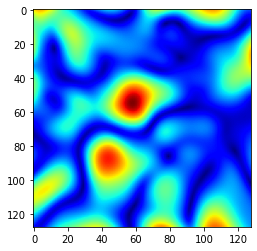

Loss  2.34499645:  62%|██████▏   | 623/1000 [12:00:36<40:06:23, 382.98s/it]

In [ ]:
import jax
import optax

# Define your gradient function
grad_fn = jax.value_and_grad(ns_torus.loss, has_aux=True)

# Define the training loop
def train_step(params, collocs, opt_state):
    # Compute loss and gradients
    (loss, new_loc_w), grads = grad_fn(params, collocs)

    # Apply gradients to update the parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

BS = 1024
for i in (pbar:= tqdm(range(EPOCHS))):
    collocs = sobol_sample(np.array([0,0,0]), np.array([2*np.pi, 2*np.pi, 1]), BS)
    
    params, opt_state, loss = train_step(params, collocs, opt_state)

    if i % 10 == 0: # dont waste a lot of time printing
        pbar.set_description(f"Loss {loss: .8f}")
        
        t0 = jnp.zeros_like(ns_torus.x_star)
        (u,v) = ns_torus.neural_net_fn(params, ns_torus.x_star, ns_torus.y_star, t0)
        w0 = ns_torus.w_net_fn(params, ns_torus.x_star, ns_torus.y_star, t0)
        
        u0_loss = jnp.mean((u - ns_torus.u0)**2)
        v0_loss = jnp.mean((v - ns_torus.v0)**2)
        w0_loss = jnp.mean((w0 - ns_torus.w0)**2)
        print(u0_loss, v0_loss, w0_loss)

        (u,v) = ns_torus.neural_net_fn(params, ns_torus.x_star, ns_torus.y_star, jnp.zeros_like(ns_torus.x_star))
        normflow = np.sqrt(u**2 + v**2).reshape((128, 128))
        plt.imshow(normflow, cmap="jet")
        plt.show()

In [128]:
jnp.abs(ns_torus.u0).mean(), jnp.abs(ns_torus.v0).mean(), jnp.abs(ns_torus.v0).mean()

(Array(0.78641665, dtype=float32),
 Array(0.88003886, dtype=float32),
 Array(0.88003886, dtype=float32))

In [129]:
jnp.abs(u).mean(), jnp.abs(v).mean()

(Array(0.5700111, dtype=float32), Array(0.57200587, dtype=float32))

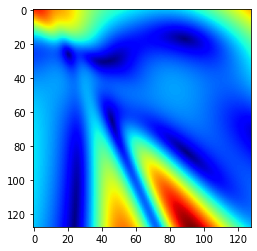

In [130]:
(u,v) = ns_torus.neural_net_fn(params, ns_torus.x_star, ns_torus.y_star, jnp.zeros_like(ns_torus.x_star))

normflow = np.sqrt(u**2 + v**2).reshape((128, 128))
plt.imshow(normflow, cmap="jet")

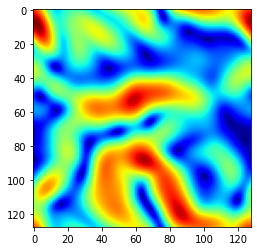

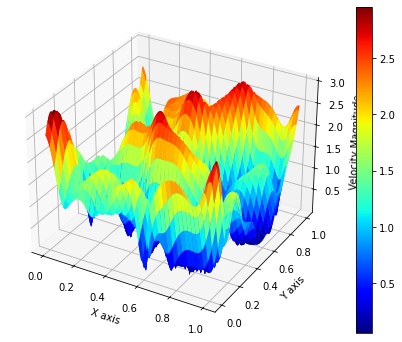

In [134]:
def plot_velocity_field(normflow, grid_size=128):
    x, y = np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, normflow, cmap="jet", edgecolor="none")
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Velocity Magnitude')
    plt.colorbar(ax.plot_surface(X, Y, normflow, cmap="jet", edgecolor="none"))
    plt.show()
    
normflow = np.sqrt(ns_torus.u0**2 + ns_torus.v0**2).reshape((128, 128))
plt.imshow(normflow, cmap="jet")
plot_velocity_field(normflow)

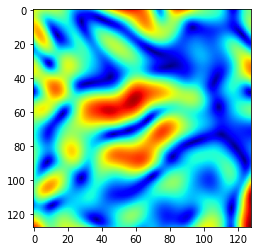

In [132]:
normflow = np.sqrt((u - ns_torus.u0)**2 + (v - ns_torus.v0)**2).reshape((128, 128))
plt.imshow(normflow, cmap="jet")

In [17]:
import jax.numpy as jnp

u, v, w, x, y, t = load_ns_data()

x_star, y_star, t_star = jnp.meshgrid(x, y, t, indexing='ij')
# Filter points where t_star < 1
mask = t_star < 1
x_filtered = x_star[mask]
y_filtered = y_star[mask]
t_filtered = t_star[mask]
u.shape

(128, 128, 201)

In [18]:
u = u[:, :, t<1]
v = v[:, :, t<1]

normflow = np.sqrt(u**2 + v**2)
animate_3d_array(normflow, interval=100)

In [19]:
(u_hat,v_hat) = ns_torus.neural_net_fn(params, x_filtered, y_filtered, t_filtered)
u_hat = u_hat.reshape(128, 128, -1)
v_hat = v_hat.reshape(128, 128, -1)

normflow = np.sqrt(u_hat**2 + v_hat**2)
animate_3d_array(normflow, interval=200)

In [20]:
collocs.shape

(2048, 3)